In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
from datetime import *
import math

In [2]:
ping_csv = pd.read_csv("../data/measure_ping.csv")
bw_csv = pd.read_csv("../data/measure_bw.csv")
weather_csv = pd.read_csv("../data/measure_weather.csv")

In [3]:
ping_array = np.array(ping_csv)
bw_array = np.array(bw_csv)
weather_array = np.array(weather_csv)

## Fonction

In [4]:
def dictonary_to_tuple(dic):
    array_tuple = []
    for type,mean in dic.items():
        array_tuple.append((type,mean))
    return array_tuple

"""
    Work for dictonary with formet : {'key' : x}
"""
def print_dict_as_sorted_tuble(dic):
    array_tuple = dictonary_to_tuple(dic)
    array_tuple.sort(key=lambda tup: tup[1])
    print(array_tuple)

In [5]:
"""
    Fusion csv as a np.array of measure and weather_csv : the measure of weather
"""
def fusion_with_weather(csv, weather_csv):
    fusion = []
    index2 = 0
    for i in range(len(csv)):
        if(index2 >= len(weather_csv)):
            return fusion;
        date1 = datetime.strptime(csv[i][0][0:13], "%Y-%m-%d %H")
        date2 = datetime.strptime(weather_csv[index2][0][0:13], "%Y-%m-%d %H") + timedelta(hours=1)
        if(date1 == date2):
            fusion.append(np.ndarray.tolist(csv[i]) + np.ndarray.tolist(weather_csv[index2][1:]))
        elif(date1 > date2):
            i -= 1
            index2 +=1
    return fusion

"""
    Create a dictionnary with key = weather_type and value the ping measure took with this weather
"""
def create_weather_ping_dict(weather_type, ping_weather_array, server=[]):
    weather_ping_dict = {}
    for type in weather_type:
        weather_ping_dict[type] = []

    for entry in ping_weather_array:
        if(server==[]): #Take ping measure of all servers
            weather_ping_dict[entry[6].split("/")[7].split(".")[0]].append(entry[0:6])
        elif(server != []): #Take only ping of the selected server
            if(entry[1] in server):
                weather_ping_dict[entry[6].split("/")[7].split(".")[0]].append(entry[0:6])
    return weather_ping_dict

"""
    Compute mean pings of a string array of double, ignore NaN
"""
def mean_ping(pings):   
    array = literal_eval(pings)
    measures = np.array(array).astype(np.double)
    
    tot = 0
    non_nan = 0
    for i in range(len(measures)):
        if(not math.isnan(measures[i])):
            tot += measures[i]
            non_nan += 1
    if(non_nan == 0):
        return float('NaN')
    return tot/non_nan

"""
    Compute mean ping from a ditonary, ignore NaN
"""
def mean_ping_resp_weather(weather_ping_measure_dict, key):
    weather_pings = {}
    for type in key:
        weather_pings[type] = []

    for type in weather_ping_measure_dict.keys():
        tot = 0
        non_nan = 0;
        for mes in weather_ping_measure_dict[type]:
            mean = mean_ping(mes[2])
            if(math.isnan(mean)):
                continue
            tot += mean_ping(mes[2])
            non_nan += 1;
        if(non_nan == 0):
            print("ALL measurement are NaN")
            weather_pings[type] = 'NaN'
        weather_pings[type] = tot/non_nan
    return weather_pings

"""
    dict {"weather" : [all pings]} from dict from create_weather_ping_dict
"""
def dict_weather_all_pings(dic):
    weather_pings = {}
    for key in dic.keys():
        weather_pings[key] = []
        tmp = []
        for mes in dic[key]:
            ping_string = mes[2].replace('[','')
            ping_string = ping_string.replace(']','')
            ping_string = ping_string.replace(" 'NaN',",'') #remove NaN
            ping_string = ping_string.replace(", 'NaN'",'') #remove NaN
            ping_string = ping_string.replace("'NaN',",'') #remove NaN
            pings = np.fromstring(ping_string, sep=',').tolist()
            tmp += pings
        weather_pings[key] = tmp
    return weather_pings

## Data

### Serveur

In [6]:
servers = np.unique(ping_array[:,1]).tolist()
servers.remove("iperf.par2.as49434.net") # remove iperf.par2.as49434.net because it stop working
print(servers)

['iperf.biznetnetworks.com', 'iperf.eenet.ee', 'iperf.scottlinux.com', 'speedtest.uztelecom.uz']


### Météo

In [7]:
weather_cond = np.unique(weather_array[:,1])
weather_type = []
for cond in weather_cond:
    weather_type.append(cond.split("/")[7].split(".")[0])
weather_type = np.unique(weather_type)

print("Type de météo collecté :\n")
print(weather_type)

Type de météo collecté :

['cloudy' 'cover' 'lightcloudy' 'lightrain' 'lightsun' 'mostcloudy' 'rain'
 'sun']


In [8]:
weather_type_measurment = {}
for type in weather_type:
    weather_type_measurment[type] = 0
    
for entry in weather_array:
    weather_type_measurment[entry[1].split("/")[7].split(".")[0]] += 1;
    
print("nombre de mesures pour chaque type de météo :\n")  
print_dict_as_sorted_tuble(weather_type_measurment)

nombre de mesures pour chaque type de météo :

[('mostcloudy', 1), ('rain', 1), ('lightsun', 2), ('lightrain', 4), ('cloudy', 17), ('lightcloudy', 19), ('sun', 24), ('cover', 27)]


### Pings

In [9]:
ping_weather_array = fusion_with_weather(ping_array, weather_array) #Array fusionné
weather_ping_measure_dict = create_weather_ping_dict(weather_type, ping_weather_array) #Dict {"weather" : [ping measure]}

In [10]:
weather_pings = dict_weather_all_pings(weather_ping_measure_dict)

<ipython-input-5-0c18dc2da368>:89: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  pings = np.fromstring(ping_string, sep=',').tolist()


<ipython-input-35-9862d5573a75>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(weather_type)


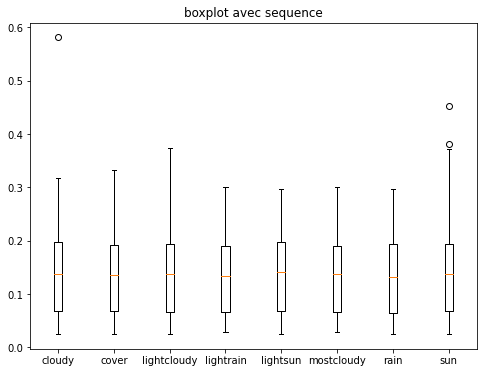

In [35]:
xl = len(weather_type)

fig, ax = plt.subplots(figsize=(xl, 6))

#labels
ax.set_xticklabels(weather_type)
#xlabels = [item.get_text() for item in ax.get_xticklabels()]
#xlabels[1] = weather_type[1]

for i in range(xl):
    ax.boxplot(weather_pings[weather_type[i]], positions = [i])
plt.title('boxplot avec sequence')
plt.show()